In [2]:
from featureranker.rankers import *
from featureranker.utils import *
from featureranker.plots import *

import pandas as pd
from sklearn.datasets import load_diabetes
import warnings
warnings.filterwarnings('ignore')


# 1 hot encoding
# forest higher weight
# location --> integer, learned embeddings, natural language

/Users/tiko/featureranker/feat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
hawaii_counties = ['15Hawaii', '15Honolulu', '15Kalawao', '15Kauai', '15Maui']

main_file_path = 'merged_data_april12.csv'

df_main = pd.read_csv(main_file_path)
if 'statecounty' in df_main.columns:
    print("'statecounty' column exists")
else:
    print("'statecounty' column does not exist. Here are the available columns:")
    print(df_main.columns)

df_hawaii = df_main[df_main['statecounty'].isin(hawaii_counties)]

print(df_hawaii)


df_main = df_hawaii


# columns: ,statecounty,allrace_cvd_mortality_per_100k_2018_2020,api_cvd_mortality_per_100k_2018_2020
# !!!! can also do a weighted score of API and total data
target_file_path = 'api_cvd_mortality.csv'
df_target = pd.read_csv(target_file_path, index_col=0)

df_target['statecounty'] = df_target['statecounty'].apply(
    lambda x: x.split()[0])

#remove duplicates based on the modified statecounty column
df_target = df_target.drop_duplicates(subset='statecounty', keep='first')

allRaceCVD = df_target.columns[2]
APICVD = df_target.columns[1]

# Impute missing values in the second column with values from the third column
df_target[allRaceCVD] = df_target[allRaceCVD].fillna(
    df_target[APICVD])

df = pd.merge(df_main, df_target, on='statecounty', how='inner')

print(len(df))


df = df.drop(columns=['statecounty']) # Remove the statecounty column

# Set the target variable
target = 'api_cvd_mortality_per_100k_2018_2020'

df = df.drop(columns=['allrace_cvd_mortality_per_100k_2018_2020'])


df = df.drop(
    columns=[
        'Asian/PacificIslanderDepression_ % Prevalence__mmd2020',
        'Asian/PacificIslanderDepression_ % Prevalence__mmd2019',
        'Asian/PacificIslanderDepression_ % Prevalence__mmd2018',
        'Asian/PacificIslanderDepression_ % Prevalence__mmd2017',
        'Asian/PacificIslanderDepression_ % Prevalence__mmd2016'
    ],
    errors='ignore'
)

df = df.drop(
    columns=[
        'Asian/PacificIslanderAnxietyDisorders_%Prevalence__mmd2019',
        'Asian/PacificIslanderAnxietyDisorders_%Prevalence__mmd2018',
        'Asian/PacificIslanderAnxietyDisorders_%Prevalence__mmd2017'
    ],
    errors='ignore'
)

df = df.drop(
    columns=[
        'Asian/PacificIslanderDepression_%Prevalence__mmd2016',
        'Asian/PacificIslanderDepression_%Prevalence__mmd2017',
        'Asian/PacificIslanderDepression_%Prevalence__mmd2018',
        'Asian/PacificIslanderDepression_%Prevalence__mmd2019',
        'Asian/PacificIslanderDepression_%Prevalence__mmd2020',
    ],
    errors='ignore'
)


df = df.drop(
    columns=[
        'percent_pop_taking_medicacine_for_hypertension_control_Places_BRFSS_2021',
        'HealthOutcome_percent_pop_with_coronary_heart_diseases_PLACES_BRFSS_2021',
        'HealthOutcome_percent_pop_with_diagnosed_Diabetes_PLACES_BRFSS_2021',
        'HealthOutcome_percent_pop_with_asthma_Places_BRFSS_2021',
        'HealthOutcome_percent_pop_with_obesity_Places_BRFSS_2021',
        'HealthOutcome_percent_pop_with_arthritis_Places_BRFSS_2021',
        'HealthOutcome_percent_pop_with_cancer_exclude_skincancer_Places_BRFSS_2021',
        'HealthOutcome_percent_pop_with_chronic_kidney_diseases_Places_BRFSS_2021',
        'HealthOutcome_percent_pop_with_stroke_PLACES_BRFSS_2021',
        'HealthOutcome_percent_pop_with_highcholesterol_PLACES_BRFSS_2021',
        
    ],
    errors='ignore'
)





# Print the remaining columns in the dataframe
print(df.shape)

'statecounty' column exists
    statecounty Park_within_Half_Mile_of_API_population_CDCEHTracking_2020  \
530    15Hawaii                                                 92           
531  15Honolulu                                              1,256           
532   15Kalawao                                                 77           
533     15Kauai                                                126           
534      15Maui                                                190           

    Park_within_One_Mile_of_API_population_CDCEHTracking_2020  \
530                                                157          
531                                              1,624          
532                                                 77          
533                                                194          
534                                                255          

     Total_population_ACS2016_2020  Total_NHPI_ACS2016_2020  \
530                         201350               

In [20]:
import numpy as np
from sklearn.impute import SimpleImputer

for col in df.columns:
    if df[col].dtype == 'object':
        # Replace commas and convert to numeric
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')



# Remove columns with more than 10% missing values
threshold = len(df) * 0.1
df = df.dropna(thresh=threshold, axis=1)

# Separate features and target variable
target = 'api_cvd_mortality_per_100k_2018_2020'
X = df.drop(columns=[target])
y = df[target]








# Impute missing values in the remaining data
imputer = SimpleImputer(strategy='mean')  # For numerical data
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

y = pd.to_numeric(y, errors='coerce')


# target_imputer = SimpleImputer(strategy='mean')
# y_imputed = pd.DataFrame(target_imputer.fit_transform(y.values.reshape(-1, 1)))

y_ipmuted = y.fillna(0)

#  if 'column_name' is categorical:
# categorical_imputer = SimpleImputer(strategy='most_frequent')
# X_imputed['column_name'] = categorical_imputer.fit_transform(X[['column_name']])

# Now X_imputed has no missing values and is ready for further processing


print(len(X_imputed))
print(len(y_ipmuted))

5
5


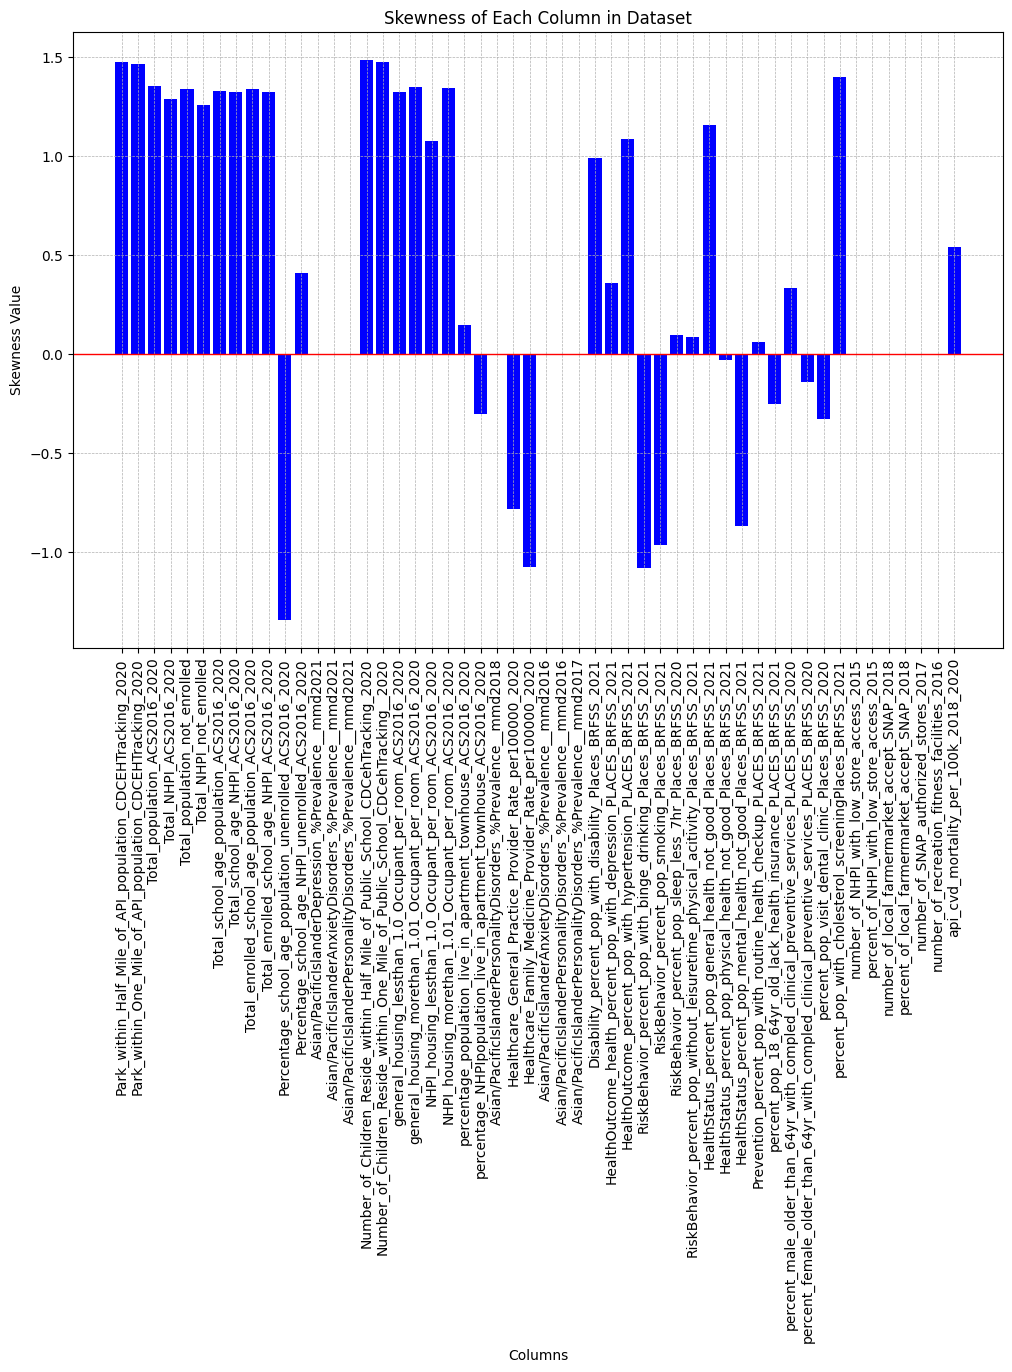

In [21]:
from scipy.stats import skew

skewness = df.apply(skew, axis=0)  # axis=0 calculates it column-wise

# Print the skewness values
# Plotting the skewness values
# You can adjust the size to fit all your columns if necessary
# You can adjust the size to fit all your columns if necessary
plt.figure(figsize=(12, 8))
# Using blue color for bars
plt.bar(skewness.index, skewness.values, color='blue')
plt.xticks(rotation=90)  # Rotate labels if there are many columns
plt.title('Skewness of Each Column in Dataset')
plt.xlabel('Columns')
plt.ylabel('Skewness Value')
# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Add a line at skewness = 0 for reference
plt.axhline(0, color='red', linewidth=1)
plt.show()

In [22]:
rankings = regression_ranking(X_imputed, y_ipmuted, predict=False)
scoring = voting(rankings)
plot_rankings(rankings, title='Regression example all methods')
plot_after_vote(scoring, title='Regression example full ensemble')

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

260
(5, 51)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bootstrap=False, max_depth=90, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.0s


/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input a

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=120; total time=   0.2s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=230; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=670; total time=   0.8s
[CV] END bootstrap=False, max_depth=90

/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input a

[CV] END colsample_bytree=0.9444444444444444, gamma=0.3333333333333333, learning_rate=0.023853323044733008, max_depth=3, min_child_weight=7, n_estimators=129, reg_alpha=2.1544346900318834, reg_lambda=0.1, subsample=0.7222222222222222; total time=   0.1s
[CV] END colsample_bytree=0.9444444444444444, gamma=0.3333333333333333, learning_rate=0.023853323044733008, max_depth=3, min_child_weight=7, n_estimators=129, reg_alpha=2.1544346900318834, reg_lambda=0.1, subsample=0.7222222222222222; total time=   0.1s
[CV] END colsample_bytree=0.9444444444444444, gamma=0.3333333333333333, learning_rate=0.023853323044733008, max_depth=3, min_child_weight=7, n_estimators=129, reg_alpha=2.1544346900318834, reg_lambda=0.1, subsample=0.7222222222222222; total time=   0.1s
[CV] END colsample_bytree=0.7777777777777778, gamma=0.16666666666666666, learning_rate=0.05689810202763908, max_depth=44, min_child_weight=10, n_estimators=359, reg_alpha=21.54434690031882, reg_lambda=0.21544346900318834, subsample=0.9444

/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]
/Users/tiko/featureranker/feat/lib/python3.12/site-packages/featureranker/utils.py:109: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(y_true, y_pred)[0]


[CV] END colsample_bytree=0.8888888888888888, gamma=0.4444444444444444, learning_rate=0.20961440008267682, max_depth=44, min_child_weight=5, n_estimators=464, reg_alpha=2.1544346900318834, reg_lambda=0.21544346900318834, subsample=0.7222222222222222; total time=   0.2s
[CV] END colsample_bytree=0.8888888888888888, gamma=0.4444444444444444, learning_rate=0.20961440008267682, max_depth=44, min_child_weight=5, n_estimators=464, reg_alpha=2.1544346900318834, reg_lambda=0.21544346900318834, subsample=0.7222222222222222; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.13572088082974532, max_depth=23, min_child_weight=1, n_estimators=464, reg_alpha=1.0, reg_lambda=21.54434690031882, subsample=0.9444444444444444; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.13572088082974532, max_depth=23, min_child_weight=1, n_estimators=464, reg_alpha=1.0, reg_lambda=21.54434690031882, subsample=0.9444444444444444; total time=   0.2s
[CV] END colsa

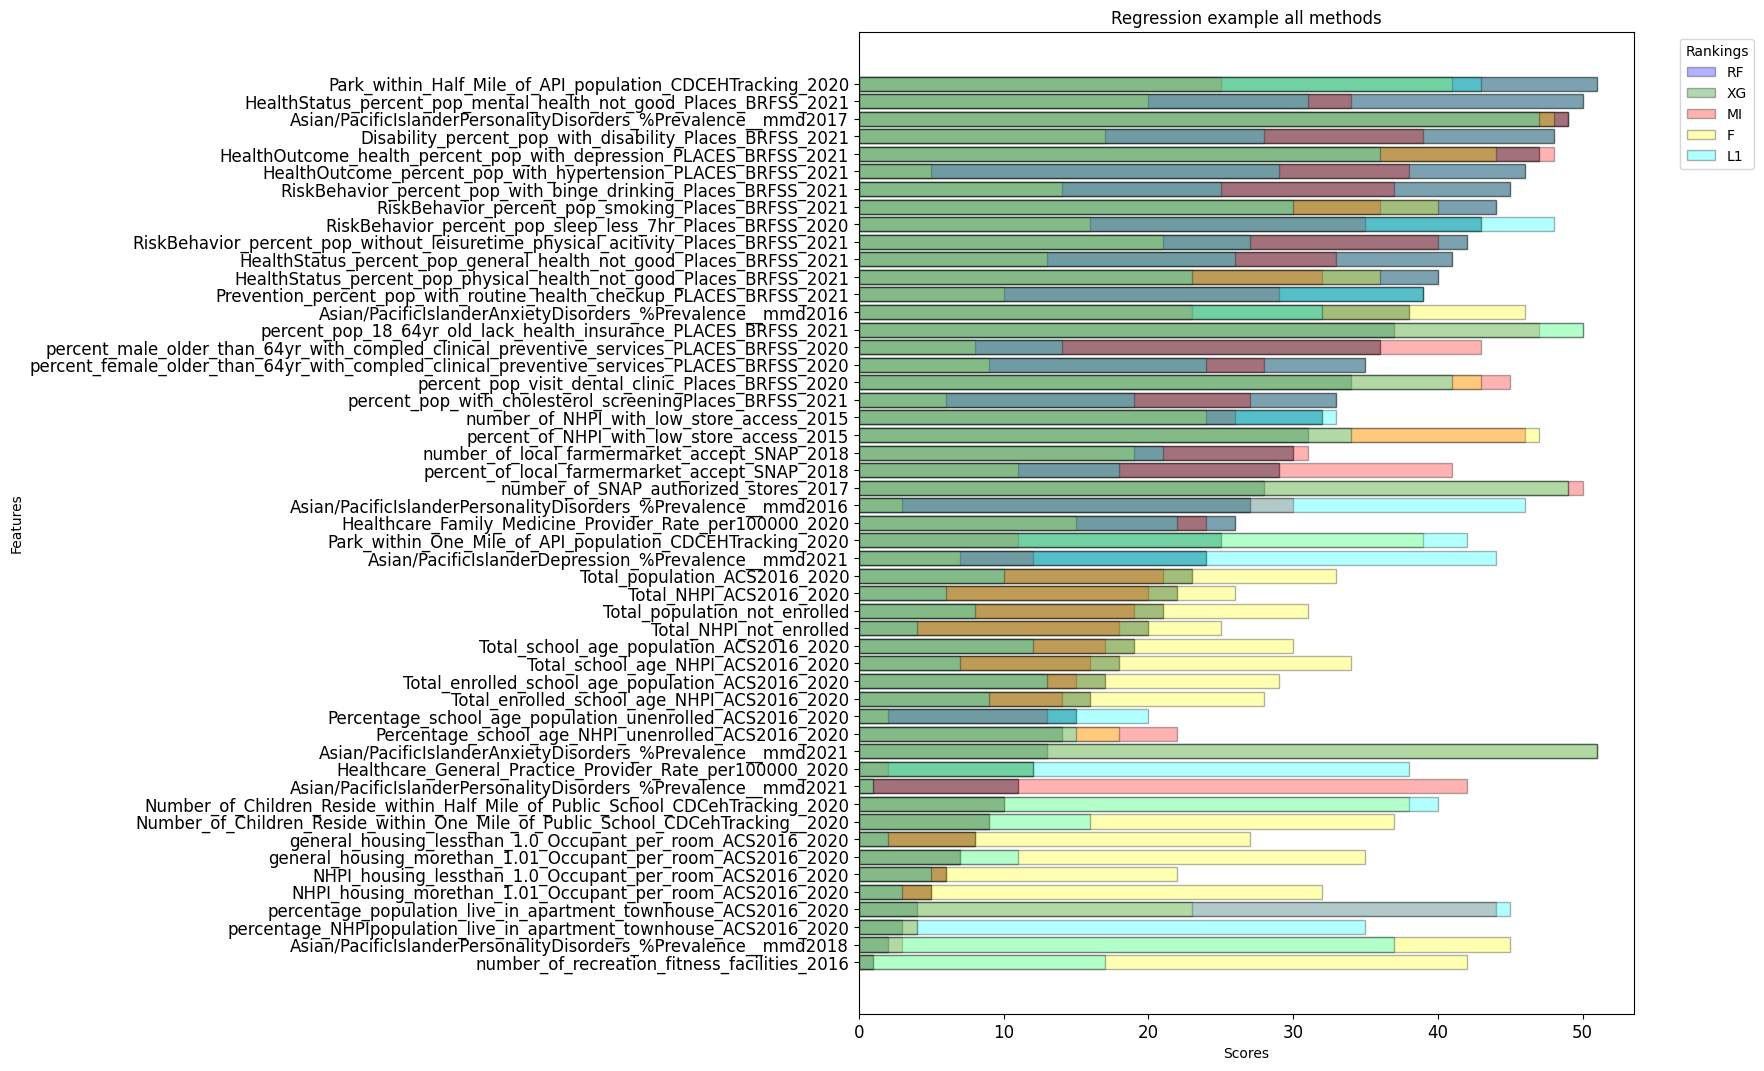

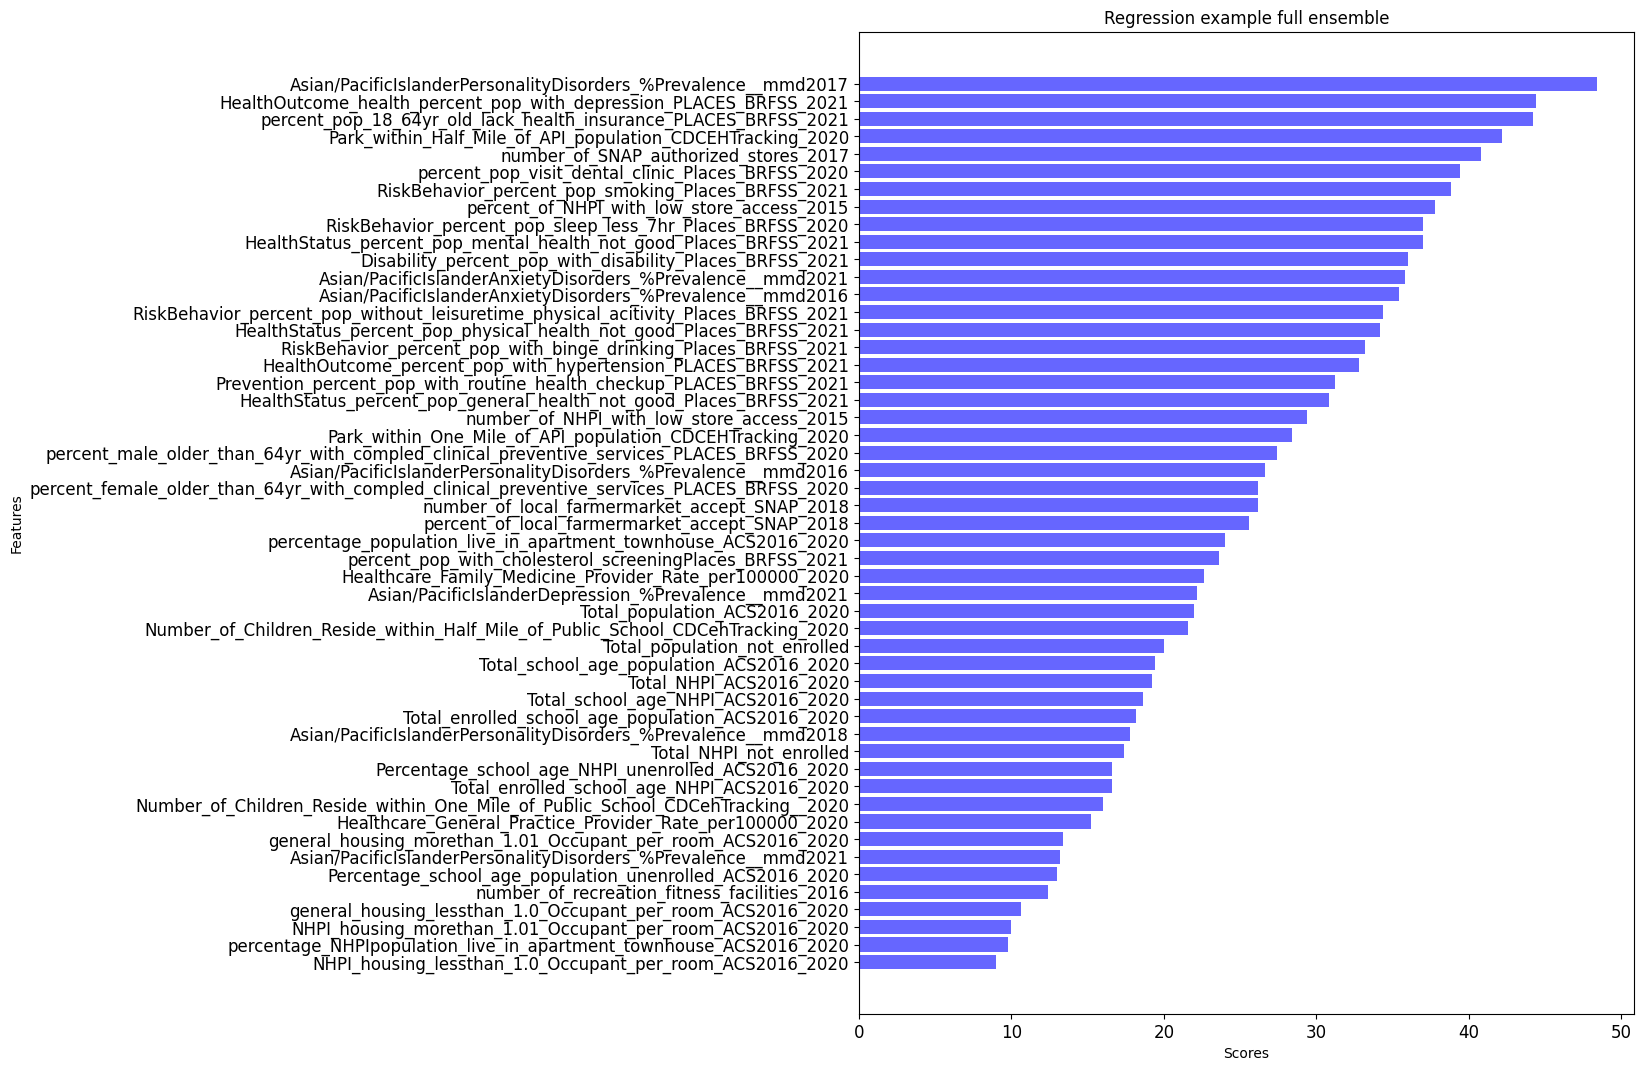

In [23]:
df_cleaned = df.dropna(subset=[target])

print(df_cleaned.size)

X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]


print(X.shape)
# For numerical data, mean imputation is a common choice
imputer = SimpleImputer(strategy='mean')

X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

rankings = regression_ranking(X_imp, y, predict=False)
scoring = voting(rankings)
plot_rankings(rankings, title='Regression example all methods')
plot_after_vote(scoring, title='Regression example full ensemble')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END bootstrap=False, max_depth=90, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; tot

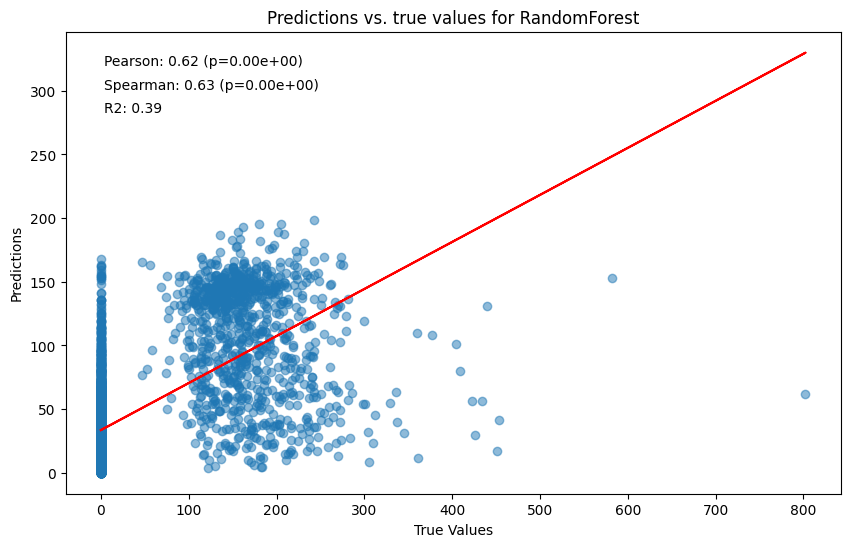

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.5555555555555556, gamma=0.5, learning_rate=0.5, max_depth=50, min_child_weight=1, n_estimators=100, reg_alpha=4.6415888336127775, reg_lambda=100.0, subsample=0.7777777777777778; total time=  10.7s
[CV] END colsample_bytree=0.5555555555555556, gamma=0.5, learning_rate=0.5, max_depth=50, min_child_weight=1, n_estimators=100, reg_alpha=4.6415888336127775, reg_lambda=100.0, subsample=0.7777777777777778; total time=  11.4s
[CV] END colsample_bytree=0.5555555555555556, gamma=0.5, learning_rate=0.5, max_depth=50, min_child_weight=1, n_estimators=100, reg_alpha=4.6415888336127775, reg_lambda=100.0, subsample=0.7777777777777778; total time=  11.7s
[CV] END colsample_bytree=0.9444444444444444, gamma=0.3333333333333333, learning_rate=0.023853323044733008, max_depth=3, min_child_weight=7, n_estimators=129, reg_alpha=2.1544346900318834, reg_lambda=0.1, subsample=0.7222222222222222; total time=   0.6s
[CV] END 

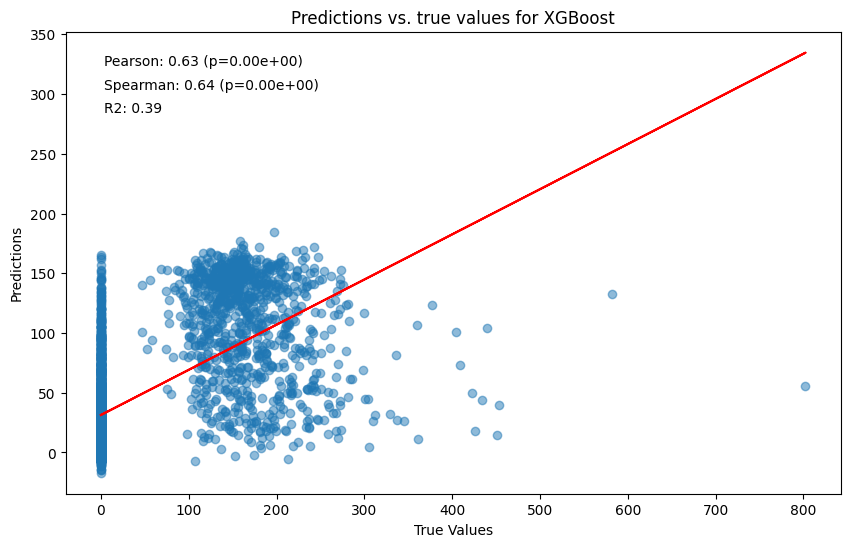

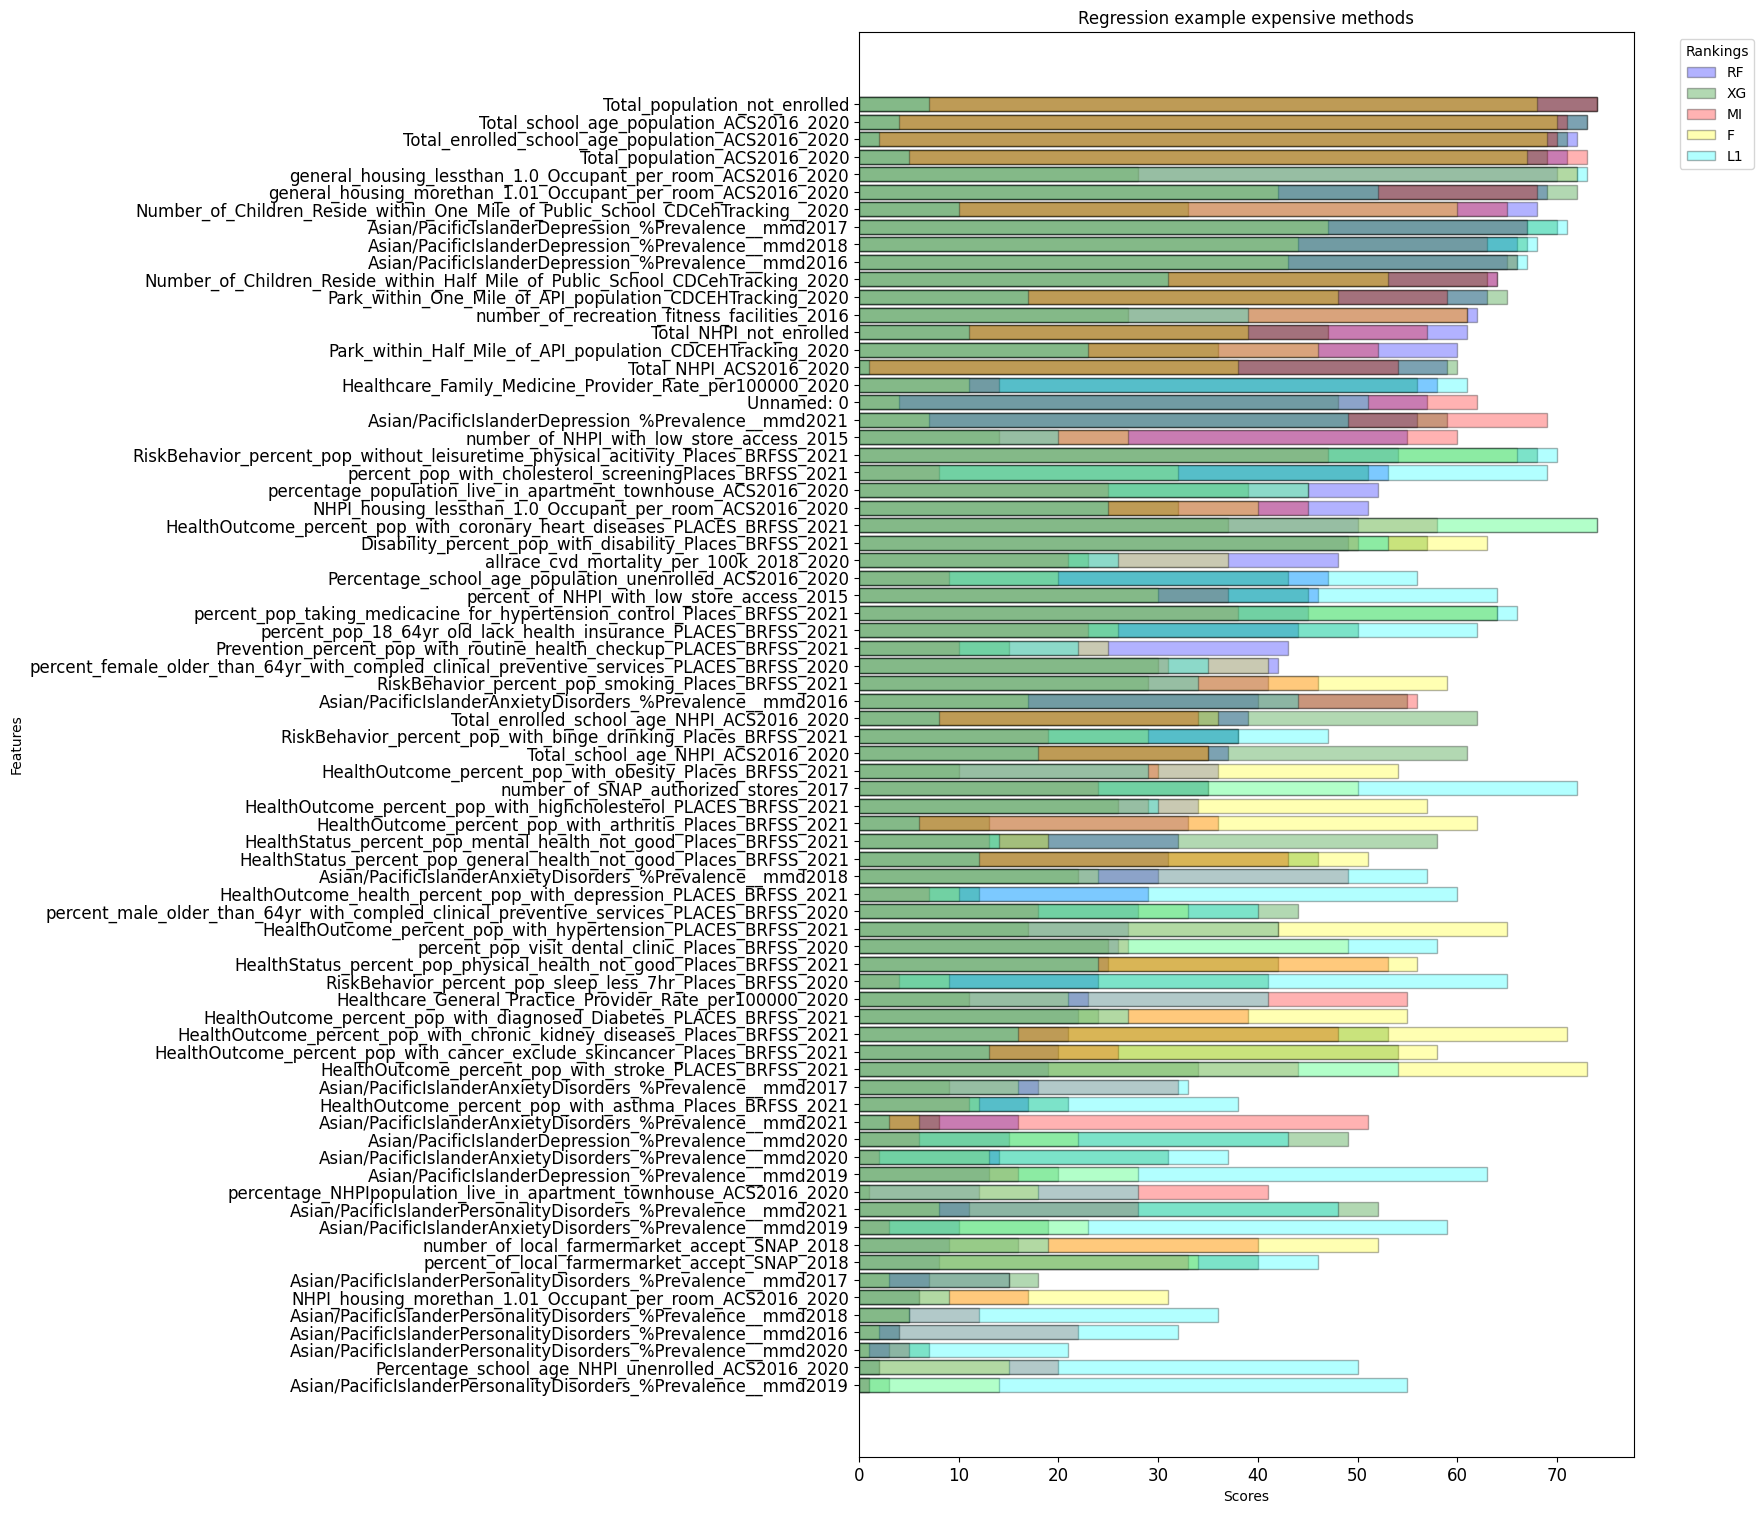

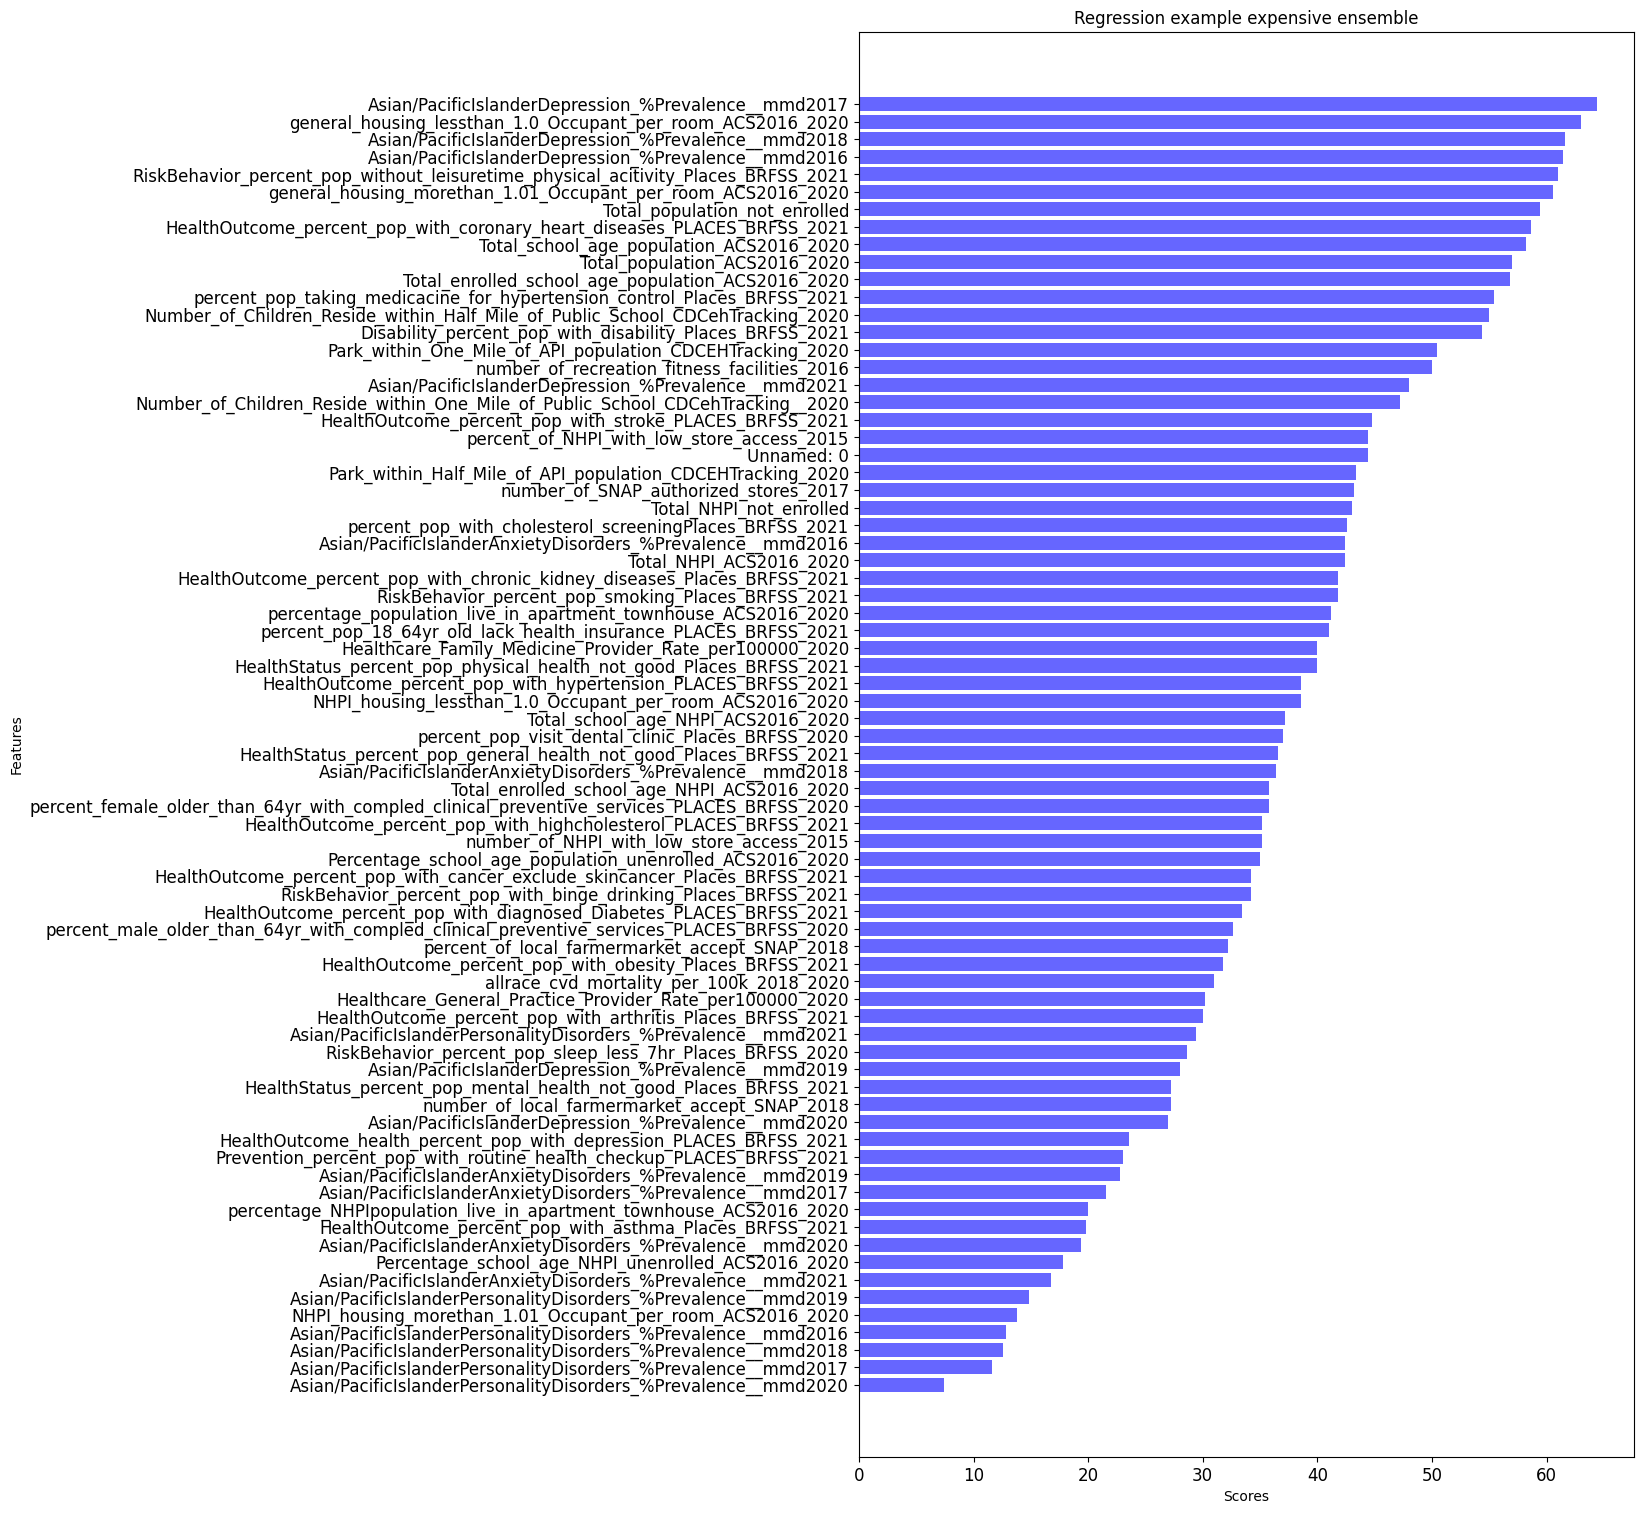

In [10]:
rankings = regression_ranking(
    X_imputed, y_ipmuted, cv=5, num_runs=30, scale=1e-30, num_alphas=10000, predict=True)
scoring = voting(rankings)
plot_rankings(rankings, title='Regression example expensive methods')
plot_after_vote(scoring, title='Regression example expensive ensemble')



In [11]:
rankings = regression_ranking(
    X_imp, y, cv=5, num_runs=30, scale=1e-30, num_alphas=10000, predict=True)
scoring = voting(rankings)
plot_rankings(rankings, title='Regression example expensive methods')
plot_after_vote(scoring, title='Regression example expensive ensemble')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 